In [1]:
using Pkg
Pkg.activate("/media/mat/HDD/AdaptiveTransportMap/")

 Activating environment at `/media/mat/HDD/AdaptiveTransportMap/Project.toml`


In [2]:
using Revise
using LinearAlgebra
using AdaptiveTransportMap
using Statistics
using Distributions
using Test
using ForwardDiff
using SpecialFunctions
using OrthoMatchingPursuit
using BenchmarkTools
using MultivariateStats

┌ Info: Precompiling AdaptiveTransportMap [bdf749b0-1400-4207-80d3-e689c0e3f03d]
└ @ Base loading.jl:1278
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been discarded
└ @ RecipesBase ~/.julia/packages/RecipesBase/92zOw/src/RecipesBase.jl:116
┌ Warning: Type annotations on keyword arguments not currently supported in recipes. Type information has been

In [3]:
using Plots
default(tickfont = font("CMU Serif", 9), 
        titlefont = font("CMU Serif", 14), 
        guidefont = font("CMU Serif", 12),
        legendfont = font("CMU Serif", 10),
        grid = false)
# Plots.font("sans-serif")
# clibrary(:colorbrewer)
# gr()
pyplot()

using LaTeXStrings
# PyPlot.rc("text", usetex = "true")
# rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
# rcParams["text.usetex"] = true;
PyPlot.rc("font", family = "CMU Serif")
PyPlot.matplotlib[:rc]("mathtext",fontset="cm")        #computer modern font 
PyPlot.matplotlib[:rc]("font",family="serif",size=12)

### Working from samples

In [8]:
Nx = 20
Ny = 5
Ne = 1000
maxrank = min(Nx, Ny)
r = maxrank
H = rdnortho(Ny)[:,1:maxrank]*Diagonal(map(i->100/(i^1.8) + 1.0, 1:maxrank))*rdnortho(Nx)[:,1:maxrank]'

svdH = deepcopy(svd(H))
UH = svdH.U
VH = Matrix(svdH.Vt')
ΛH = svdH.S

norm(H-UH*Diagonal(ΛH)*VH')

8.118800881064739e-14

In [9]:
ΛH

5-element Array{Float64,1}:
 101.0000000000001
  29.71745887492588
  14.841454884616855
   9.246924442330592
   6.518918645844862

In [10]:
σy = 0.5
Σy = Diagonal(σy^2*ones(Ny))
ϵy = AdditiveInflation(zeros(Ny), σy)

σx = 1.5
Σx = Diagonal(σx^2*ones(Nx))
ϵx = AdditiveInflation(zeros(Nx), σx)

AdditiveInflation(20, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [2.25 0.0 … 0.0 0.0; 0.0 2.25 … 0.0 0.0; … ; 0.0 0.0 … 2.25 0.0; 0.0 0.0 … 0.0 2.25], [1.5 0.0 … 0.0 0.0; 0.0 1.5 … 0.0 0.0; … ; 0.0 0.0 … 1.5 0.0; 0.0 0.0 … 0.0 1.5])

In [14]:
X = zeros(Ny+Nx, Ne)

# Samples from the standard normal distribution
ϵx(X, Ny+1, Ny+Nx)

# Compute observations
observe((x, t)->H*x, X, 0.0, Ny, Nx)

ϵ = ϵy.m .+ ϵy.σ*randn(Ny, Ne)

5×1000 Array{Float64,2}:
  0.185111  -0.659046    0.270044   …  -0.302073    0.373599   0.196822
  0.338086   0.0901589   0.111295      -0.299368    0.11269   -0.551898
 -0.654211   0.499798   -0.109264       0.0843242   0.108454   1.16738
  0.169783   0.302081    0.0374515     -0.406067   -0.257692  -0.336557
  0.12406    0.485221    0.203762       0.0464992  -0.770631  -0.471569

In [21]:
Σxx = Symmetric(cov(state(X, Ny, Nx)'))0
Σxy = 1/(Ne-1)*(state(X, Ny, Nx) .- mean(state(X,Ny,Nx);dims = 2)[:,1])*(meas(X, Ny, Nx) .- mean(meas(X,Ny,Nx);dims = 2)[:,1])'
Σyy = Symmetric(cov(meas(X, Ny, Nx)'))

H̃sample = Σyy^(-0.5)*H*Σxx^(0.5)

10×20 Array{Float64,2}:
  0.233612   0.240668   0.0561868  …   0.483907   -0.419535    0.308213
  0.11066   -0.292536   0.112167       0.0754631   0.255938   -0.0242303
  0.235163   0.213762   0.439091       0.14815    -0.154209   -0.114387
  0.116043   0.385338  -0.134277      -0.156097   -0.0223838  -0.192664
 -0.527279  -0.032348   0.076833       0.0294728   0.113166    0.0260132
  0.190545  -0.191156  -0.0125011  …  -0.0892166  -0.214133    0.233957
  0.112994  -0.234703   0.19587        0.183486   -0.133216   -0.0406115
  0.118879  -0.466968  -0.0897827      0.123317   -0.0570826   0.153953
  0.273992  -0.051695   0.195821       0.132442    0.288244   -0.0493455
 -0.119243   0.229419   0.24241       -0.316531   -0.161622    0.170994

In [22]:
Cx = zeros(Nx, Nx)
Cy = zeros(Ny, Ny)

Dx = Diagonal(std(view(X, Ny+1:Ny+Nx, :); dims = 2)[:,1])
Dy = Diagonal(std(view(X, 1:Ny, :); dims = 2)[:,1]);

@inbounds for i=1:Ne
    H̃i = ϵy.σ\(H*Dx)
    Cx .+= 1/Ne*H̃'*H̃
    Cy .+= 1/Ne*H̃*H̃'
end

In [23]:
eigen_Cx = eigen(Symmetric(Cx); sortby =  λ -> -λ)
eigen_Cx.values

20-element Array{Float64,1}:
 91253.72821331288
 11952.02420736476
  3622.757176266407
  1646.4552100131978
   901.1812973847126
   540.8574870166276
   376.74379484936406
   266.7060651616754
   199.71093982003327
   156.56093257489917
     3.699782385551048e-10
     2.0211514727023307e-10
     9.19129831164322e-11
     5.829059648332874e-11
     1.3714874299257305e-11
    -5.878301672311934e-12
    -9.360968405003372e-12
    -8.308863221849134e-11
    -1.2831924195386345e-10
    -2.8412792133924467e-10

In [24]:
V = eigen_Cx.vectors[:,1:r]

20×10 Array{Float64,2}:
 -0.108445   -0.21209    -0.217044   …   0.268345    0.243656    0.123023
  0.281243    0.148071   -0.143082       0.335779   -0.150995   -0.545857
  0.163077    0.0576858   0.0329286      0.0838657   0.408571    0.151491
 -0.0879378  -0.239034   -0.289799      -0.288604    0.29636    -0.295116
  0.144776    0.124005    0.0490417     -0.235855   -0.302286   -0.0739756
 -0.129258   -0.0411563   0.261701   …   0.181575   -0.0835559   0.323014
  0.0942875  -0.152704   -0.0865239     -0.337395    0.383679   -0.152416
 -0.0852746  -0.305849    0.0133399     -0.23369    -0.23904    -0.255212
  0.190425    0.17494    -0.0701825     -0.288072    0.144309    0.0664321
 -0.0705495  -0.177408   -0.230014       0.033395   -0.108679    0.17957
  0.483979   -0.051015   -0.490564   …  -0.130287   -0.135301    0.23319
 -0.0688384   0.292562    0.110044      -0.0754681   0.0125473   0.188104
  0.186686    0.122351   -0.391281       0.225671    0.0628398   0.280749
 -0.196331    

In [25]:
eigen_Cy = eigen(Symmetric(Cy); sortby =  λ -> -λ)
eigen_Cy.values

10-element Array{Float64,1}:
 91253.72821331264
 11952.024207364751
  3622.757176266243
  1646.4552100132655
   901.181297384926
   540.8574870163217
   376.7437948491203
   266.70606516171955
   199.71093981994443
   156.5609325744651

In [26]:
U = eigen_Cy.vectors[:,1:r]

10×10 Array{Float64,2}:
  0.0598114  -0.754261    0.0225927  …  -0.241388  -0.0463066   0.365469
 -0.0889484  -0.323968   -0.207645       0.558104  -0.598961    0.0854543
  0.434651    0.279375    0.361003      -0.14593   -0.522667   -0.0199859
  0.373825   -0.0232341  -0.534163       0.095756   0.286466    0.202457
  0.34352     0.0675715   0.161984       0.432289  -0.0863599   0.0784291
  0.248772    0.137482   -0.415566   …   0.230244  -0.0236275  -0.190219
  0.396333   -0.347696   -0.15375       -0.318222  -0.108061   -0.691992
 -0.23442    -0.269506    0.347461       0.42009    0.237447   -0.494982
 -0.517294    0.150051   -0.405582      -0.220077  -0.401163   -0.183533
 -0.0180265   0.0896453  -0.181443       0.183648   0.216451   -0.133652

In [27]:
Ktrue = ϵx.Σ*H'*inv(H*ϵx.Σ*H'+ϵy.Σ)

20×10 Array{Float64,2}:
  0.0116721     0.00812497    0.0515678    …   0.0334804    -0.0245449
  0.0652627    -0.047477     -0.00102689      -0.00852283    0.00287588
  0.0064689     0.0327132     0.0587961        0.0529633     0.0136428
  0.0365589     0.0613103     0.00485194       0.0276802     0.011364
  0.010906     -0.020124     -0.0186979       -0.0445749     0.0363507
 -0.0212029    -0.0419615     0.0105021    …   0.0341965     0.0111711
 -0.00218691    0.102895      0.0393241       -0.00511465    0.00468546
  0.0179954    -0.00966064   -0.0284586       -0.0183248    -0.0154677
 -0.0160823     0.0301036     0.0279232        0.0405657    -0.0247505
 -0.000625878  -0.0257699    -0.0224254        0.00340824    0.00193759
 -0.0423942     0.00862068   -0.0329774    …  -0.0122315     0.00642794
 -2.68634e-5   -0.0215124     0.00107496       0.0299984     0.0321189
  0.000523241  -0.0371843     0.0114443        0.0613804     0.00960142
 -0.0168932     0.0346816     0.0232275       -0.

In [32]:
Kr = sqrt(cov(state(X,Ny, Nx)'))*V*Diagonal(sqrt.(eigen_Cy.values[1:r])./(1.0 .+ sqrt.(eigen_Cy.values[1:r]).^2))*(U'*inv(ϵy.σ))

20×10 Array{Float64,2}:
 -0.00533816    0.0175145   -0.0524766   …  -0.0553569    0.0436521
 -0.0664166     0.039655     0.0189177       0.0358076    0.0396206
 -0.00131576   -0.0330152   -0.0348056      -0.0424867    0.0208013
 -0.0228927    -0.0649004   -0.0209033       0.0214786   -0.0131635
 -0.016047      0.0324057    0.0364188       0.00957741  -0.0121093
  0.0361587     0.0206896    0.0166381   …   0.014332     0.0115728
  0.008632     -0.0756074   -0.0201708      -0.0203234    0.0373767
 -0.00452848   -0.0027607    0.0172731       0.0565743   -0.00648763
  0.0146203    -0.0597701   -0.0284053       0.0239506    0.0139841
  0.00444355    0.033016    -0.0108657      -0.0120374   -0.0359889
  0.0422        0.00282352   0.00917849  …   0.0108607   -0.0148428
 -0.00787618    0.00167676   0.00495388     -0.00309115  -0.0375559
  0.00110258    0.0212498   -0.0214336      -0.00235792  -0.00758169
 -0.000834703  -0.00807993  -0.0291105      -0.047375     0.0167082
  0.0225675    -0.0460

In [31]:
norm(K-Ktrue)/norm(Ktrue)

0.09589123847629907

In [29]:
K = Σxx*H'*inv(Σyy)

20×10 Array{Float64,2}:
  0.0105063    0.00773183   0.0522728   …   0.0308289   -0.0226015
  0.0664189   -0.0483205    0.00097323     -0.00762351   0.00277857
  0.00500415   0.0316937    0.0582621       0.0545296    0.00937866
  0.0369153    0.060204     0.00607416      0.0302009    0.0133018
  0.00574065  -0.0129822   -0.0207845      -0.0479173    0.0393424
 -0.0196502   -0.0456881    0.0066762   …   0.0334857    0.0120852
 -0.0032944    0.104635     0.0354668      -0.0101743    0.0057018
  0.0193059   -0.0100607   -0.0319203      -0.0241764   -0.0152753
 -0.0154185    0.0304269    0.0299529       0.0433419   -0.0260611
 -0.00482489  -0.0248459   -0.0209841       0.00742154   0.00177954
 -0.0410414    0.00589153  -0.0335234   …  -0.0133501    0.00470446
 -0.00127736  -0.0185494    0.00098876      0.0221307    0.0334975
  0.00141987  -0.0352645    0.00781139      0.058312     0.0125022
 -0.0137861    0.0365148    0.0230808      -0.00295712  -0.00871794
 -0.0258353    0.0440314    0.020

In [16]:
svdH̃sample = svd(H̃sample);

In [17]:
svdH̃sample

SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
  0.0218353   0.329906    0.131455    0.0719433  …  -0.336961    -0.198003
  0.481965    0.325689   -0.439341   -0.169865       0.387613    -0.364287
 -0.530449   -0.0303216  -0.219711    0.230453       0.588943     0.123821
 -0.163532   -0.0619089  -0.491965   -0.395894       0.0846502   -0.00645877
 -0.292542    0.586665   -0.143426   -0.193094      -0.253062     0.417118
  0.289991    0.193956    0.130683    0.6117     …   0.271641     0.113142
 -0.480518    0.307213    0.375986   -0.037047       0.193406    -0.58077
  0.0777523  -0.32979     0.385512   -0.469715       0.188452    -0.0955029
 -0.150918   -0.363094   -0.0846726   0.15233       -0.00592585   0.163051
  0.17239     0.252117    0.4057     -0.315369       0.414016     0.50292
singular values:
10-element Array{Float64,1}:
 1.009209692479329
 1.0062379409709985
 1.0036008270187347
 1.0029506589428967
 1.001329465005774
 0.9976548895780435
 0.9915969944

In [18]:
Klowrank = Σx^(1/2)*V*Diagonal(Λ)*inv(Diagonal(Λ).^2 + I)*U'*Σy^(-1/2)

LoadError: [91mUndefVarError: Λ not defined[39m

In [201]:
isposdef(Symmetric(Σxy*inv(Σyy)*(Σxy')))

false

In [205]:
E1 = eigen(Symmetric(Σxy*(Σyy\(Σxy'))), Σxx)

GeneralizedEigen{Float64,Float64,Array{Float64,2},Array{Float64,1}}
values:
20-element Array{Float64,1}:
 -3.736850343961709e-16
 -3.0305094340771137e-16
 -1.923381154300831e-16
 -1.4238510144807033e-16
 -9.300044222400317e-17
  3.4479841235178085e-17
  1.3410353537158534e-16
  2.1078159296229402e-16
  2.995416215529736e-16
  4.689211302293456e-16
  0.9570211827183169
  0.9659209804444706
  0.9686105857075465
  0.9726839687208598
  0.9789657439959808
  0.9814310543103316
  0.9887800893351203
  0.9926040586080717
  0.9961585552968009
  0.9992011445399831
vectors:
20×20 Array{Float64,2}:
 -0.0751051    0.244383    -0.00443213  …   0.157721     0.212473
  0.146489    -0.0226617   -0.239765       -0.0932904   -0.163616
 -0.110238    -0.00996158  -0.0130902      -0.575474     0.0639061
  0.140373     0.143651    -0.101987       -0.135806    -0.00815613
 -0.120679    -0.00663185  -0.0888664      -0.085245     0.0399172
 -0.0192349    0.0272652    0.233491    …  -0.0845982   -0.141855
  0.115

In [215]:
Λ = E1.values./(1.0 .-E1.values)

20-element Array{Float64,1}:
   -3.7368503439617073e-16
   -3.030509434077113e-16
   -1.9233811543008305e-16
   -1.423851014480703e-16
   -9.300044222400317e-17
    3.4479841235178085e-17
    1.3410353537158537e-16
    2.1078159296229407e-16
    2.995416215529737e-16
    4.689211302293458e-16
   22.26727591050266
   28.343567187153656
   30.857873825967403
   35.60853913151168
   46.54149611038874
   52.85335369667177
   88.1272693578725
  134.20929209787457
  259.31872830740076
 1250.7909059278932

In [76]:
svd(H̃)

SVD{Float64,Float64,Array{Float64,2}}
U factor:
10×10 Array{Float64,2}:
  0.0641204   0.254384    -0.183958  -0.428634   …  -0.573138    0.606823
 -0.290928    0.00401832  -0.529376  -0.0533508      0.0616348  -0.0551907
  0.266514    0.276454    -0.324761  -0.146112      -0.0318523  -0.422608
 -0.101319   -0.734992    -0.286928  -0.440352       0.194789    0.106851
 -0.464208    0.0949348    0.396239  -0.50769       -0.26221    -0.407861
  0.438384    0.0578712   -0.291812  -0.322354   …   0.0604909  -0.322774
 -0.160714    0.42229     -0.342238   0.0710781      0.183573    0.0647777
 -0.163705   -0.264538    -0.300814   0.473722      -0.527065   -0.0847683
 -0.0957332  -0.104994    -0.11734    0.0826278     -0.41496    -0.394481
  0.600409   -0.216651     0.185956   0.0146778     -0.269546   -0.0342671
singular values:
10-element Array{Float64,1}:
 1.0126563692273145
 1.0094742386434066
 1.0045156753655875
 1.0022953349083663
 0.9952130408768515
 0.9872278249739405
 0.984362710333514

In [21]:
Σyy = 

α = 1.0
λ0 = 500
τ = 1e-9

λtilde0 = 1.0
τtilde = 1e-9
ΛH = map(i-> λ0/(i^α) + τ, 1:min(Ny, Nx))
ΛX = map(i-> λtilde0/(i^α) + τtilde, 1:Nx)

20-element Array{Float64,1}:
 1.000000001
 0.500000001
 0.33333333433333334
 0.250000001
 0.200000001
 0.16666666766666666
 0.14285714385714285
 0.125000001
 0.1111111121111111
 0.100000001
 0.09090909190909091
 0.08333333433333333
 0.07692307792307693
 0.07142857242857142
 0.06666666766666667
 0.062500001
 0.058823530411764705
 0.05555555655555555
 0.05263157994736842
 0.050000001

In [25]:
U = Matrix(qr(randn(Ny, Ny)).Q)
V = Matrix(qr(randn(Ny, Ny)).Q)

20×20 Array{Float64,2}:
 -0.385419    0.279758   -0.116839    -0.062175   …   0.298618    0.188885
  0.0924087  -0.41927    -0.104403    -0.0991016     -0.190351   -0.100921
 -0.248725   -0.0647208  -0.0435458   -0.16483       -0.227559    0.21432
  0.360298   -0.107573    0.158463    -0.234489       0.103325    0.274374
  0.39222    -0.115525    0.150809    -0.0752712      0.135093   -0.0973899
  0.0672663  -0.082833    0.015547    -0.448899   …   0.120159    0.1809
 -0.03138     0.301628   -0.421907    -0.168517      -0.11352    -0.195903
  0.149903    0.103326    0.0255276    0.185168       0.146221    0.377058
 -0.13661    -0.0478563   0.193874    -0.0736007     -0.0737505   0.0600682
 -0.238123    0.0563366   0.0455886    0.0367086     -0.19281    -0.00233535
 -0.030822   -0.163139   -0.390238     0.142061   …  -0.032612   -0.428519
 -0.0898115  -0.152397    0.175962    -0.0161426      0.564832   -0.116649
 -0.0629619  -0.22733    -0.177667    -0.453958       0.119715   -0.228413


In [ ]:
H = rand(Ny, Nx)

σy = 0.1
Σy = Diagonal(σy^2*ones(Ny))
ϵy = AdditiveInflation(zeros(Ny), σy)

σx = 1.5
Σx = Diagonal(σx^2*ones(Nx))
L = cholesky(inv(Σx))
ϵx = AdditiveInflation(zeros(Nx), σx)

LoadError: [91mUndefVarError: X not defined[39m

LoadError: [91mUndefVarError: Ne not defined[39m

In [6]:
Σyy = copy(Σy);

LoadError: [91mUndefVarError: Σy not defined[39m

In [7]:
@time Σy\(Σxy')

LoadError: [91mUndefVarError: Σxy not defined[39m

In [164]:
@time Σxy*(Σy\(Σxy'));

  0.000021 seconds (3 allocations: 4.141 KiB)


In [162]:
eigen(Hermitian(Σxx - Σxy*inv(Σy)*Σxy'));

In [161]:
E1 = eigen(Σxx, Σxx - Σxy*inv(Σy)*Σxy');

In [150]:
Λ1 = zeros(min(Nx,Ny))

for i in axes(Λ,1)
    @show E1.values[end-i+1]
    Λ1[i] = E1.values[end-i+1]/(1-E1.values[end-i+1])
end

E1.values[(end - i) + 1] = 5533.683492171553
E1.values[(end - i) + 1] = 768.4434872518958
E1.values[(end - i) + 1] = 358.5800517087799
E1.values[(end - i) + 1] = 187.10343240248906
E1.values[(end - i) + 1] = 137.52803671519075


In [84]:
X = zeros(Ny+Nx, Ne)
ϵx(X, Ny+1, Ny+Nx)

In [85]:
xstar = σx*randn(Nx)
ystar = H*xstar

5-element Array{Float64,1}:
  3.1863782281677557
  1.2961341870904126
  0.6382307854274372
  2.243377328071246
 -1.0139311553757233

In [86]:
X

25×500 Array{Float64,2}:
  0.0         0.0        0.0        …   0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
  0.0         0.0        0.0            0.0        0.0         0.0
 -1.2458     -1.33112   -1.64702    …   3.36754   -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998   -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933   2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269  -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634   0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167  -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673    0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324  -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       -0.333976  -1.61289     0.99464

In [87]:
# Compute observations
observe((x, t)->H*x, X, 0.0, Ny, Nx)

In [88]:
H*X[Ny+1:Ny+Nx,1]

5-element Array{Float64,1}:
 -4.201837580911975
 -2.1394534272246384
 -4.019694321430913
 -3.075109147097886
 -4.203807085694468

In [89]:
# Perturb observations
ϵy(X, 1, Ny)

In [90]:
H̃ = Σy^(-1/2)*H*Σx^(1/2)

5×20 Array{Float64,2}:
 13.2246   12.1639    8.33884  12.5696   …  0.33596   13.0077     6.104
 11.7709    4.02518   4.32466  12.2453      3.82649    4.51892    0.736347
 14.3812    7.6828   12.7421   14.2567      0.309371   0.571132   5.6817
 12.7464    1.10851   2.9518   12.5377      2.96307    9.68206   14.5612
  9.11181   3.50321   1.7109    3.99807     3.86428    9.44018    6.83744

In [91]:
svdH̃ = svd(H̃)
r = Ny
Λ = svdH̃.S[1:r]
U = svdH̃.U[:,1:r]
V = Matrix(svdH̃.Vt')[:,1:r]

norm(U*Diagonal(Λ)*V'-H̃)

6.670033592382955e-14

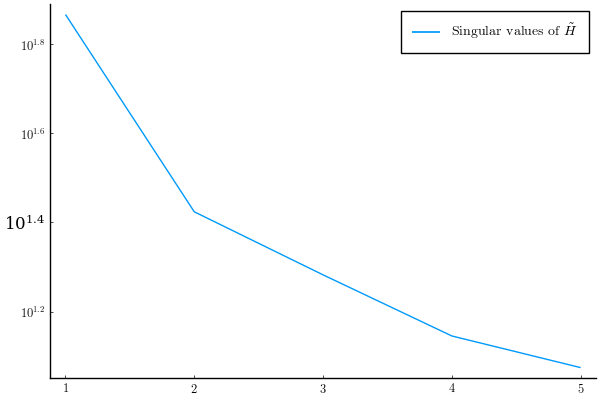

In [92]:
plot(Λ, yscale = :log10, label = L"Singular values of $\tilde{H}$")

In [93]:
Σy

5×5 Diagonal{Float64,Array{Float64,1}}:
 0.01   ⋅     ⋅     ⋅     ⋅ 
  ⋅    0.01   ⋅     ⋅     ⋅ 
  ⋅     ⋅    0.01   ⋅     ⋅ 
  ⋅     ⋅     ⋅    0.01   ⋅ 
  ⋅     ⋅     ⋅     ⋅    0.01

In [94]:
X

25×500 Array{Float64,2}:
 -4.13629    -0.831244   0.717565   …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904    1.03149       -0.0446603  -2.30553     2.6002
 -4.08742     0.606595   0.793833      -1.4667      0.910888    3.49455
 -3.03034    -1.86637    0.992155       1.39849     0.262881    1.31985
 -4.09688    -2.23186    0.409984       0.218713   -1.91686     1.1933
 -1.2458     -1.33112   -1.64702    …   3.36754    -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998    -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933    2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269   -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634    0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167   -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673     0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324   -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       

In [95]:
X̃ = copy(X)

25×500 Array{Float64,2}:
 -4.13629    -0.831244   0.717565   …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904    1.03149       -0.0446603  -2.30553     2.6002
 -4.08742     0.606595   0.793833      -1.4667      0.910888    3.49455
 -3.03034    -1.86637    0.992155       1.39849     0.262881    1.31985
 -4.09688    -2.23186    0.409984       0.218713   -1.91686     1.1933
 -1.2458     -1.33112   -1.64702    …   3.36754    -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998    -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933    2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269   -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634    0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167   -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673     0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324   -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       

In [96]:
view(X̃,1:Ny, :) .= Σy^(-1/2)*view(X, 1:Ny, :)

5×500 view(::Array{Float64,2}, 1:5, :) with eltype Float64:
 -41.3629   -8.31244   7.17565  -79.8323   …   -3.2971    -18.3319   42.1481
 -21.8269  -13.1904   10.3149     5.98496      -0.446603  -23.0553   26.002
 -40.8742    6.06595   7.93833  -65.0499      -14.667       9.10888  34.9455
 -30.3034  -18.6637    9.92155  -30.393        13.9849      2.62881  13.1985
 -40.9688  -22.3186    4.09984  -15.8272        2.18713   -19.1686   11.933

In [97]:
@time view(X̃,Ny+1:Ny+Nx, :) .= Σx^(-1/2)*view(X, Ny+1:Ny+Nx, :)

  0.000150 seconds (17 allocations: 78.922 KiB)


20×500 view(::Array{Float64,2}, 6:25, :) with eltype Float64:
 -0.830531   -0.887413  -1.09801    …   2.24502    -0.0385918   0.70321
 -1.52463     2.17562   -0.271358      -1.04665    -0.421929    0.622044
 -0.469627    2.47093   -1.06895       -0.0992884   1.9379      1.90871
 -0.0423554   0.525269   1.01961       -0.442179   -0.106734   -0.593515
 -0.489888   -0.869489  -0.237863      -0.573089    0.149428    0.860822
  0.836328   -0.625207  -0.69303    …  -0.411445   -1.3325      0.0822692
  0.258944   -0.601023  -1.70955        0.931155    0.397813    1.67433
  0.443987   -1.00311    1.34579       -0.545549   -0.66273    -0.859249
  0.691504   -0.446074  -0.820293      -0.222651   -1.07526     0.663096
 -0.68108    -0.465749   0.582494       1.28106     0.118654    1.88932
 -0.666418    0.494957   1.34751    …   0.154679   -1.2969     -0.837
 -1.95927    -0.985845   0.945772       0.850864   -0.0961618  -1.23269
  0.617864   -0.557774   0.36103       -1.99929     0.964902    1.312

In [98]:
mean(X̃; dims = 2)

25×1 Array{Float64,2}:
 -0.7823400688534918
 -1.6111181975140163
  0.1681611995322183
 -2.6036276784051893
 -2.262391214861934
  0.05670419576942602
  0.05145452693243453
  0.008355510272549278
 -0.01691546809605259
  0.02231291052328124
  0.07277969298086735
  0.035829804521281886
  0.011367217784992296
  0.025756768601362116
 -0.043646282130600136
 -0.059677091191211146
 -0.05563785099735409
 -0.04510014532669326
 -0.010456416776879716
 -0.03674417550200221
 -0.03724606038167628
 -0.04711627894955761
 -0.015217172265051536
 -0.04170016287513491
 -0.07923653502070366

In [99]:
H̃ - Σy^(-1/2)*H*Σx^(1/2)

5×20 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0

20×5 Array{Float64,2}:
 -0.149439     0.145923     0.158918     0.197409     -0.12959
  0.345397    -0.00452612  -0.0316272   -0.392728      0.0770016
 -0.00200294   0.0671384    0.209074    -0.0914481    -0.0915309
 -0.191262     0.341819     0.170131     0.319211     -0.425661
  0.0385124   -0.310455    -0.0251588   -0.0297553     0.389881
  0.223667    -0.26863     -0.0313412   -0.104689      0.194512
  0.0246272    0.238984    -0.0581879   -0.144172      0.0465056
  0.0331696    0.0538537    0.157497    -0.0113525    -0.12959
  0.188242    -0.148307     0.192718    -0.353031      0.164898
  0.191805    -0.0945659   -0.180594     0.272121     -0.194787
 -0.0625104    0.257766    -0.0518823   -0.148945      0.177464
  0.156351    -0.149314    -0.0673382   -0.000561701   0.152606
  0.0137476    0.12555     -0.0322645    0.0511158     0.00630486
  0.327596     0.264226    -0.236392    -0.09597      -0.28114
 -0.197927    -0.251453     0.344922    -0.0535286     0.287324
  0.0542617    

In [101]:
K = Σx*H'*inv(H*Σx*H'+Σy)

20×5 Array{Float64,2}:
 -0.149439     0.145923     0.158918     0.197409     -0.12959
  0.345397    -0.00452612  -0.0316272   -0.392728      0.0770016
 -0.00200294   0.0671384    0.209074    -0.0914481    -0.0915309
 -0.191262     0.341819     0.170131     0.319211     -0.425661
  0.0385124   -0.310455    -0.0251588   -0.0297553     0.389881
  0.223667    -0.26863     -0.0313412   -0.104689      0.194512
  0.0246272    0.238984    -0.0581879   -0.144172      0.0465056
  0.0331696    0.0538537    0.157497    -0.0113525    -0.12959
  0.188242    -0.148307     0.192718    -0.353031      0.164898
  0.191805    -0.0945659   -0.180594     0.272121     -0.194787
 -0.0625104    0.257766    -0.0518823   -0.148945      0.177464
  0.156351    -0.149314    -0.0673382   -0.000561701   0.152606
  0.0137476    0.12555     -0.0322645    0.0511158     0.00630486
  0.327596     0.264226    -0.236392    -0.09597      -0.28114
 -0.197927    -0.251453     0.344922    -0.0535286     0.287324
  0.0542617    

In [102]:
norm(Klowrank-K)

3.9330182325197666e-15

In [103]:
Xpost = deepcopy(X)

25×500 Array{Float64,2}:
 -4.13629    -0.831244   0.717565   …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904    1.03149       -0.0446603  -2.30553     2.6002
 -4.08742     0.606595   0.793833      -1.4667      0.910888    3.49455
 -3.03034    -1.86637    0.992155       1.39849     0.262881    1.31985
 -4.09688    -2.23186    0.409984       0.218713   -1.91686     1.1933
 -1.2458     -1.33112   -1.64702    …   3.36754    -0.0578877   1.05481
 -2.28695     3.26343   -0.407037      -1.56998    -0.632893    0.933066
 -0.704441    3.70639   -1.60342       -0.148933    2.90685     2.86306
 -0.0635331   0.787904   1.52941       -0.663269   -0.1601     -0.890273
 -0.734832   -1.30423   -0.356794      -0.859634    0.224142    1.29123
  1.25449    -0.937811  -1.03954    …  -0.617167   -1.99874     0.123404
  0.388416   -0.901535  -2.56433        1.39673     0.596719    2.5115
  0.665981   -1.50467    2.01868       -0.818324   -0.994095   -1.28887
  1.03726    -0.669111  -1.23044       

In [104]:
view(Xpost, Ny+1:Ny+Nx, :) .= view(X,Ny+1:Ny+Nx,:) - Klowrank*(view(X,1:Ny,:) .- ystar)

20×500 view(::Array{Float64,2}, 6:25, :) with eltype Float64:
 -0.439896   -0.891394   -1.57054   …   3.69879    -0.0518124   1.03264
 -1.75667     3.11804    -0.151626     -0.8549      0.384906    0.141436
 -0.261992    3.39323    -1.60722       0.409692    2.81784     2.29796
  0.900168    1.71224     2.12672       0.275049    0.312433   -0.390946
 -0.606666   -1.60964    -0.932347     -1.69916    -0.40073     0.840302
  1.85727    -0.936055   -0.961526  …  -0.585099   -1.86671    -0.192806
  0.508214   -0.715317   -2.67784       1.50214     1.3534      2.10493
  1.3811     -1.43008     2.26064      -0.147821   -0.816072   -1.56753
  1.45706    -1.54461    -1.51146       0.0331741  -1.80498    -0.246014
  0.0350743   0.70007     1.96819       2.55908     1.21246     3.95713
 -1.04421     0.767764    1.50418   …  -0.0959642  -1.45133    -1.90842
 -2.16414    -1.05967     1.55762       1.29551     0.257831   -1.96013
  1.60077    -0.236363    0.668712     -2.81476     2.08427     1.916

In [105]:
Xpost

25×500 Array{Float64,2}:
 -4.13629    -0.831244    0.717565  …  -0.32971    -1.83319     4.21481
 -2.18269    -1.31904     1.03149      -0.0446603  -2.30553     2.6002
 -4.08742     0.606595    0.793833     -1.4667      0.910888    3.49455
 -3.03034    -1.86637     0.992155      1.39849     0.262881    1.31985
 -4.09688    -2.23186     0.409984      0.218713   -1.91686     1.1933
 -0.439896   -0.891394   -1.57054   …   3.69879    -0.0518124   1.03264
 -1.75667     3.11804    -0.151626     -0.8549      0.384906    0.141436
 -0.261992    3.39323    -1.60722       0.409692    2.81784     2.29796
  0.900168    1.71224     2.12672       0.275049    0.312433   -0.390946
 -0.606666   -1.60964    -0.932347     -1.69916    -0.40073     0.840302
  1.85727    -0.936055   -0.961526  …  -0.585099   -1.86671    -0.192806
  0.508214   -0.715317   -2.67784       1.50214     1.3534      2.10493
  1.3811     -1.43008     2.26064      -0.147821   -0.816072   -1.56753
  1.45706    -1.54461    -1.51146    